# This notebook __doesn't need gpu__, you should be able to run it very quickly on your macbook within 5 minutes. This step by step shows how to iterate on kaggle competitions and how to make your first neural net from scratch using basic pytorch.

In [ ]:
dependencies = [
    "kagtool",
    "scikit-learn",
    "numpy",
    "matplotlib",
]

%pip install -U {" ".join(dependencies)}

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gc
import torch
import torch.nn as nn

In [2]:
# this cell works inside or oustide kaggle
from kagtool.datasets.kaggle_downloader import KaggleDownloader

dataset_name = 'digit-recognizer'

# add your creds if outside kaggle on a cloud machine
path = KaggleDownloader.build(dataset_name, username=None, key=None).load_or_fetch_kaggle_dataset()
df = pd.read_csv(path/'train.csv')
df.head()

digit-recognizer.zip: Skipping, found more recently modified local copy (use --force to force download)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 🧑‍🍳 Preprocess

### Split

In [3]:
from sklearn.model_selection import train_test_split

# Now train_df contains 80% of the data, and val_df contains 20%
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# The df contains both the labels and the pixel data
# Extract labels
x = df['label'].values
# Extract pixel data (images)
y = df.drop('label', axis=1).values
x, y.shape

(array([1, 0, 1, ..., 7, 6, 9]), (42000, 784))

### Prepare X And Y For training

> Note: For educational purpose we just gonna ignore the batch totally and load the whole all the samples at once

In [4]:
def extract_labels_and_images(df):
    x = df.drop('label', axis=1).values
    y = df['label'].values    
     # Convert to PyTorch tensors
    x_tensor = torch.from_numpy(x).float()
    y_tensor = torch.from_numpy(y).long().unsqueeze(1)
    
    return x_tensor, y_tensor

X, Y = extract_labels_and_images(train_df)
val_x, val_y = extract_labels_and_images(val_df)
X.shape, Y.shape

(torch.Size([33600, 784]), torch.Size([33600, 1]))

> Note: usually you would want to load X and Y as batches instead of the whole dataset, but I didn't both to keep it simple here.

### Checking That We Got An Image And A Label

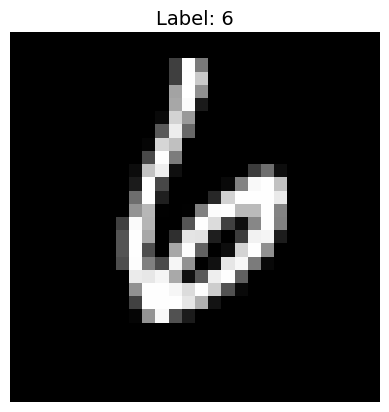

In [5]:
def np_show_img(array, title=''):
    if array.ndim == 1:  # If rank 1, reshape to 2D
        array = array.reshape(28, 28)
    plt.imshow(array, cmap='gray')
    plt.axis('off')
    plt.title(title, fontsize=14)
    plt.show()

np_show_img(X[0], title=f'Label: {Y[0].item()}')

# 🧮 Model

### Your First Multi-Layer-Perceptron (MLP)

In [6]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.layer2(x)
        return x

### Defining Shapes

In [7]:
n_input = X.shape[-1] # 784 px
n_hidden = 32 # number of neurons in the hidden layer
n_output = 10 # number of output classes 10 digits

model = MLP(n_input, n_hidden, n_output)
model

MLP(
  (layer1): Linear(in_features=784, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=10, bias=True)
  (relu): ReLU()
)

### Your First Prediction

Trying to predict 33600 images

In [8]:
model(X).shape

torch.Size([33600, 10])

### From Logits To Predictions

Your model outputs logits, to make sense of them we need to turn that into probabilities

In [9]:
def accuracy(logits, Y):
    """
    Calculate the accuracy of predictions.

    Parameters:
    logits  (torch.Tensor): Tensor of true labels in one-hot encoding, shape (n_samples, n_classes)
    Y       (torch.Tensor): Tensor of expected classes indices, shape (n_samples, 1)

    Returns:
    float: Accuracy score
    """
    # Convert one-hot encoded true labels to class indices
    predictions = torch.argmax(logits, dim=1)
    
    # Flatten Y to ensure it matches the shape of predictions
    y_pred_labels = Y.view(-1)
    
    # Compare with true labels
    correct_predictions = (y_pred_labels == predictions).sum().item()
    
    # Calculate accuracy
    accuracy = correct_predictions / logits.size(0)
    
    return accuracy

As expected the accuracy is garbage! Because we haven't tried the model yet. So let's train it.

# 🏋️‍♂️ Training

### Loss Function

First we need a loss function

In [10]:
def loss_fn(logits, Y):
    # Ensure logits are of shape (batch_size, num_classes)
    assert logits.ndimension() == 2 and logits.size(1) == 10
    # Ensure Y is of shape (batch_size, 1) and then squeeze to (batch_size,)
    assert Y.ndimension() == 2 and Y.size(1) == 1
    return nn.CrossEntropyLoss()(logits, Y.squeeze())

SGD by Hand

In [11]:
def train(model, X, Y, val_x, val_y, epochs, lr, print_epochs=True):
    for epoch in range(epochs):
        # Forward
        model.train()
        logits = model(X)
        loss = loss_fn(logits, Y)
        
        # Backward
        loss.backward()

        # Update parameters
        with torch.no_grad():
            for param in model.parameters():
                if param.grad is not None:
                    param.data -= lr * param.grad
                    param.grad.zero_()  # Zero out the gradients after each update

        # Evaluation
        model.eval()
        with torch.no_grad():
            train_acc = accuracy(model(X), Y)
            val_acc = accuracy(model(val_x), val_y)
        if print_epochs:
            print(f'Epoch {epoch+1} \t| Training Loss: {loss.item():.5f}\t| Training Accuracy: {train_acc:.5f}\t| Validation Accuracy: {val_acc:.5f}')
    return loss.item(), train_acc, val_acc


torch.manual_seed(1337)
epochs = 20
lr = 0.1
model = MLP(n_input, n_hidden, n_output)
train(model, X, Y, val_x, val_y, epochs, lr)


Epoch 1 	| Training Loss: 27.35779	| Training Accuracy: 0.11262	| Validation Accuracy: 0.10964
Epoch 2 	| Training Loss: 6496.52930	| Training Accuracy: 0.10440	| Validation Accuracy: 0.10631
Epoch 3 	| Training Loss: 253112.92188	| Training Accuracy: 0.11063	| Validation Accuracy: 0.11286
Epoch 4 	| Training Loss: 232345.82812	| Training Accuracy: 0.11101	| Validation Accuracy: 0.11357
Epoch 5 	| Training Loss: 2.28628	| Training Accuracy: 0.11107	| Validation Accuracy: 0.11381
Epoch 6 	| Training Loss: 2.28470	| Training Accuracy: 0.11143	| Validation Accuracy: 0.11429
Epoch 7 	| Training Loss: 2.28299	| Training Accuracy: 0.11223	| Validation Accuracy: 0.11476
Epoch 8 	| Training Loss: 2.28028	| Training Accuracy: 0.11241	| Validation Accuracy: 0.11488
Epoch 9 	| Training Loss: 2.27937	| Training Accuracy: 0.11250	| Validation Accuracy: 0.11488
Epoch 10 	| Training Loss: 2.27883	| Training Accuracy: 0.11286	| Validation Accuracy: 0.11536
Epoch 11 	| Training Loss: 2.27782	| Training

(2.2713379859924316, 0.11473214285714285, 0.11761904761904762)

### Not Training? We Need To Normalize!

In [12]:
model = MLP(n_input, n_hidden, n_output)
model(X)[0]

tensor([  1.1017,  11.0962,  11.3166,  -2.2534,  14.9082, -19.7100,   3.8005,
          3.8045,  -1.5773, -16.2333], grad_fn=<SelectBackward0>)

In [13]:
model = MLP(n_input, n_hidden, n_output)
model(X / 255)[0]

tensor([ 0.0914, -0.0368, -0.0310,  0.1434,  0.0885, -0.1545, -0.0038,  0.0733,
        -0.0082,  0.0474], grad_fn=<SelectBackward0>)

The reason why we need to do that, is that it's easier to optimize small numbers than big ones, think about the learning rate above, even if we update the weights by the gradients, if the weights are big, they the resulting multiplications will also be big. If we visualize parameters as movements, directions towards our goal, if every movements is big, it's hard to converge.

In [14]:
torch.manual_seed(1337)
epochs = 20
lr = 0.1
model = MLP(n_input, n_hidden, n_output)
train(model, X / X.max(), Y, val_x / val_x.max(), val_y, epochs, lr)

Epoch 1 	| Training Loss: 2.30661	| Training Accuracy: 0.13542	| Validation Accuracy: 0.13488
Epoch 2 	| Training Loss: 2.29159	| Training Accuracy: 0.14583	| Validation Accuracy: 0.14583
Epoch 3 	| Training Loss: 2.27656	| Training Accuracy: 0.15435	| Validation Accuracy: 0.15440
Epoch 4 	| Training Loss: 2.26104	| Training Accuracy: 0.16622	| Validation Accuracy: 0.16726
Epoch 5 	| Training Loss: 2.24491	| Training Accuracy: 0.18702	| Validation Accuracy: 0.19000
Epoch 6 	| Training Loss: 2.22793	| Training Accuracy: 0.21310	| Validation Accuracy: 0.21536
Epoch 7 	| Training Loss: 2.21000	| Training Accuracy: 0.24024	| Validation Accuracy: 0.24012
Epoch 8 	| Training Loss: 2.19111	| Training Accuracy: 0.27241	| Validation Accuracy: 0.27131
Epoch 9 	| Training Loss: 2.17123	| Training Accuracy: 0.30449	| Validation Accuracy: 0.30345
Epoch 10 	| Training Loss: 2.15028	| Training Accuracy: 0.33830	| Validation Accuracy: 0.33583
Epoch 11 	| Training Loss: 2.12842	| Training Accuracy: 0.3

(1.9047490358352661, 0.6412797619047619, 0.6422619047619048)

Now, it's converging!

# 🧪 Experimenting With HyperParams

### Larger? (More Neurons)

Using larger hidden size

In [15]:
# Train and evaluate models with different hidden sizes
for hidden_size in [10, 20, 40, 80]:
    model = MLP(n_input, hidden_size, n_output)
    loss, train_acc, val_acc = train(model, X / X.max(), Y, val_x / val_x.max(), val_y, epochs, lr, print_epochs=False)
    print(f'Hidden Size {hidden_size} \t| Training Loss: {loss:.5f}\t| Training Accuracy: {train_acc:.5f}\t| Validation Accuracy: {val_acc:.5f}')

Hidden Size 10 	| Training Loss: 1.84777	| Training Accuracy: 0.57107	| Validation Accuracy: 0.56524
Hidden Size 20 	| Training Loss: 2.00653	| Training Accuracy: 0.43057	| Validation Accuracy: 0.43667
Hidden Size 40 	| Training Loss: 1.85503	| Training Accuracy: 0.65479	| Validation Accuracy: 0.65286
Hidden Size 80 	| Training Loss: 1.84987	| Training Accuracy: 0.66063	| Validation Accuracy: 0.66452


### Longer?

In [16]:
# Train and evaluate models with different hidden sizes
for hidden_size in [10, 20, 40, 80]:
    model = MLP(n_input, hidden_size, n_output)
    loss, train_acc, val_acc = train(model, X / X.max(), Y, val_x / val_x.max(), val_y, 100, lr, print_epochs=False)
    print(f'Hidden Size {hidden_size} \t| Training Loss: {loss:.5f}\t| Training Accuracy: {train_acc:.5f}\t| Validation Accuracy: {val_acc:.5f}')

Hidden Size 10 	| Training Loss: 0.83191	| Training Accuracy: 0.81711	| Validation Accuracy: 0.82393
Hidden Size 20 	| Training Loss: 0.61951	| Training Accuracy: 0.85247	| Validation Accuracy: 0.85488
Hidden Size 40 	| Training Loss: 0.60518	| Training Accuracy: 0.85979	| Validation Accuracy: 0.86226
Hidden Size 80 	| Training Loss: 0.58343	| Training Accuracy: 0.86185	| Validation Accuracy: 0.86214


### Deeper?

In [17]:
class DeepNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DeepNet, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Train and evaluate models with different hidden sizes
for hidden_size in [10, 20, 40, 80]:
    model = DeepNet(n_input, hidden_size, n_output)
    loss, train_acc, val_acc = train(model, X / X.max(), Y, val_x / val_x.max(), val_y, 100, lr, print_epochs=False)
    print(f'Hidden Size {hidden_size} \t| Training Loss: {loss:.5f}\t| Training Accuracy: {train_acc:.5f}\t| Validation Accuracy: {val_acc:.5f}')

Hidden Size 10 	| Training Loss: 0.95403	| Training Accuracy: 0.75283	| Validation Accuracy: 0.74952
Hidden Size 20 	| Training Loss: 0.97217	| Training Accuracy: 0.74589	| Validation Accuracy: 0.74798
Hidden Size 40 	| Training Loss: 0.86809	| Training Accuracy: 0.79923	| Validation Accuracy: 0.80060
Hidden Size 80 	| Training Loss: 0.74327	| Training Accuracy: 0.80482	| Validation Accuracy: 0.80774


So having more layers is not necessary better, it depends. Actually adding more layers involves a bit more work in the architecture of the model, but this is beyond the scope of this little tutorial.

# 🏎️ Another Optimizer

In [18]:
def train_with_adamw(model, X, Y, val_x, val_y, epochs, lr, print_epochs=True):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        # Forward
        model.train()
        logits = model(X)
        loss = loss_fn(logits, Y)
        # Backward
        loss.backward()
        # Update parameters
        optimizer.step()

        # Evaluation
        model.eval()
        with torch.no_grad():
            train_acc = accuracy(model(X), Y)
            val_acc = accuracy(model(val_x), val_y)
        if print_epochs:
            print(f'Epoch {epoch+1} \t| Training Loss: {loss.item():.5f}\t| Training Accuracy: {train_acc:.5f}\t| Validation Accuracy: {val_acc:.5f}')
    return loss.item(), train_acc, val_acc

# Train and evaluate models with different hidden sizes
for hidden_size in [10, 20, 40, 80]:
    model = MLP(n_input, hidden_size, n_output)
    loss, train_acc, val_acc = train_with_adamw(model, X / X.max(), Y, val_x / val_x.max(), val_y, 100, lr, print_epochs=False)
    print(f'Hidden Size {hidden_size} \t| Training Loss: {loss:.5f}\t| Training Accuracy: {train_acc:.5f}\t| Validation Accuracy: {val_acc:.5f}')

Hidden Size 10 	| Training Loss: 0.32118	| Training Accuracy: 0.90693	| Validation Accuracy: 0.89369
Hidden Size 20 	| Training Loss: 0.20290	| Training Accuracy: 0.94259	| Validation Accuracy: 0.92524
Hidden Size 40 	| Training Loss: 0.20566	| Training Accuracy: 0.94354	| Validation Accuracy: 0.92905
Hidden Size 80 	| Training Loss: 0.28931	| Training Accuracy: 0.91872	| Validation Accuracy: 0.90429


(for me) the best model is 40 hidden size + adamw + 100 epochs

> Note: With better techniques you won't have to do 100 epochs.

# 👏 Kaggle Submission

### Ensembling

Ensembling = training different models and averaging their predictions

In [19]:
def ensemble(test_x):
    model = MLP(n_input, 40, n_output)
    train_with_adamw(model, X / X.max(), Y, val_x / val_x.max(), val_y, 100, lr, print_epochs=False)
    return model(test_x / test_x.max())

# loading test data
test_df = pd.read_csv(path/'test.csv')
# turn that into pixels
test_x = torch.from_numpy(test_df.values).float()
# train 5 models
learns = [ensemble(test_x) for _ in range(5)]
# average their predictions
ens_preds = torch.stack(learns).mean(0)

### Kaggle Submission

In [20]:
test_df['ImageId'] = range(1, len(test_df) + 1)
test_df['Label'] = torch.argmax(ens_preds, dim=1)
sub_df = test_df[['ImageId','Label']]
sub_df.to_csv('submission.csv', index=False)

### Thank you! I hope you enjoyed this walkthrough, if so please give it a 👍 thanks!